In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plot

In [5]:
raw_data = pd.read_csv('./datasets/ny_airbnb/AB_NYC_2019.csv')

del raw_data['reviews_per_month']
raw_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


## Splitting the training and test data
Stratifying the data based on the price and splitting it into training and test data sets

In [6]:
import sklearn
from sklearn.model_selection import train_test_split

#train_bnb, test_bnb = train_test_split(raw_data, test_size=0.2, stratify=['price'])
#train_bnb, test_bnb = train_test_split(raw_data, test_size=0.2, random_state=13)
raw_data['price_cat'] = pd.cut(raw_data['price'], bins=5, labels=['1','2','3','4','5'])
raw_data.tail()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365,price_cat
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,2,9,1
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,2,36,1
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,1,27,1
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,6,2,1
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,1,23,1


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data["price_cat"]):
    strat_train_set = raw_data.loc[train_index]
    strat_test_set = raw_data.loc[test_index]
    
del strat_train_set['price_cat']
del strat_test_set['price_cat']

## Handling missing values
Let's first check for the amount of missing values in each column and then find a way how to handle each one of them.
TODO: create transformers for all transformations below

In [8]:
strat_train_set.isna().sum()

id                                   0
name                                13
host_id                              0
host_name                           17
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8048
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [9]:
strat_train_set_copy = strat_train_set.copy()
# Fill not available names with IDs
strat_train_set['name'] = strat_train_set['name'].fillna(strat_train_set['id'])
strat_train_set['host_name'] = strat_train_set['host_name'].fillna('unkown')
strat_train_set.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,3.911600e+04,3.911600e+04,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000
mean,1.904915e+07,6.769564e+07,40.728929,-73.952271,152.983638,7.025207,23.145541,7.208073,112.648839
std,1.098875e+07,7.861319e+07,0.054540,0.046212,242.094952,19.541354,44.112838,33.096298,131.472348
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,9.490869e+06,7.901156e+06,40.690020,-73.983172,69.000000,1.000000,1.000000,1.000000,0.000000
50%,1.974327e+07,3.117519e+07,40.723060,-73.955800,107.000000,2.000000,5.000000,1.000000,45.000000
75%,2.918365e+07,1.074344e+08,40.763150,-73.936547,177.000000,5.000000,24.000000,2.000000,226.000000
max,3.648724e+07,2.743213e+08,40.912340,-73.712990,10000.000000,999.000000,629.000000,327.000000,365.000000


## Creating a pre-processing pipeline

1. Calculate the amount of days since the last review and remove the column *last_review*

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

# Currently not used, counting days since last review not working correctly
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, count_last_review_days = True):
        self.count_last_review_days = count_last_review_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):     
        # More transformations here
        if self.count_last_review_days:
            X['last_review'] = pd.to_datetime(X['last_review'])
            days_since_last_review = pd.Timestamp('20200101') - X['last_review']
            return np.c_[X, days_since_last_review]
        else:
            return np.c_[X]

In [11]:

strat_train_set['last_review'] = strat_train_set['last_review'].fillna(pd.Timestamp('20170101'))
strat_train_set['last_review'] = pd.to_datetime(strat_train_set['last_review'])

strat_train_set = strat_train_set.assign(days_since_last_review = (pd.Timestamp('20200217') - strat_train_set['last_review']))
strat_train_set['days_since_last_review'] = strat_train_set['days_since_last_review'].dt.days
strat_train_set = strat_train_set.drop('last_review', axis=1)
#strat_train_set = strat_train_set.drop('calculated_host_listings_count', axis=1)

strat_train_set.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review
47291,35677349,No Sleep Till Brooklyn!,222069293,Mariela,Brooklyn,Williamsburg,40.71556,-73.94245,Entire home/apt,275,3,0,1,362,1142
24491,19702498,Sunny 2BR Brooklyn Loft,5421054,Samuel,Brooklyn,Bushwick,40.70766,-73.92169,Entire home/apt,175,5,8,1,0,526
44681,34346014,Cosy crisp clean pad in Williamsburg,3203693,David,Brooklyn,Williamsburg,40.70996,-73.95121,Entire home/apt,100,6,1,1,7,229
17563,13812808,The trendiest block in Bedford Stuyvesant Broo...,81311292,Byron,Brooklyn,Bedford-Stuyvesant,40.68283,-73.94375,Private room,100,1,0,1,0,1142
29623,22747209,McSimon's | Cozy Private Studio | Near NYC,8113165,Cynthia And Froebel,Brooklyn,Canarsie,40.63762,-73.91004,Entire home/apt,95,3,4,2,108,410


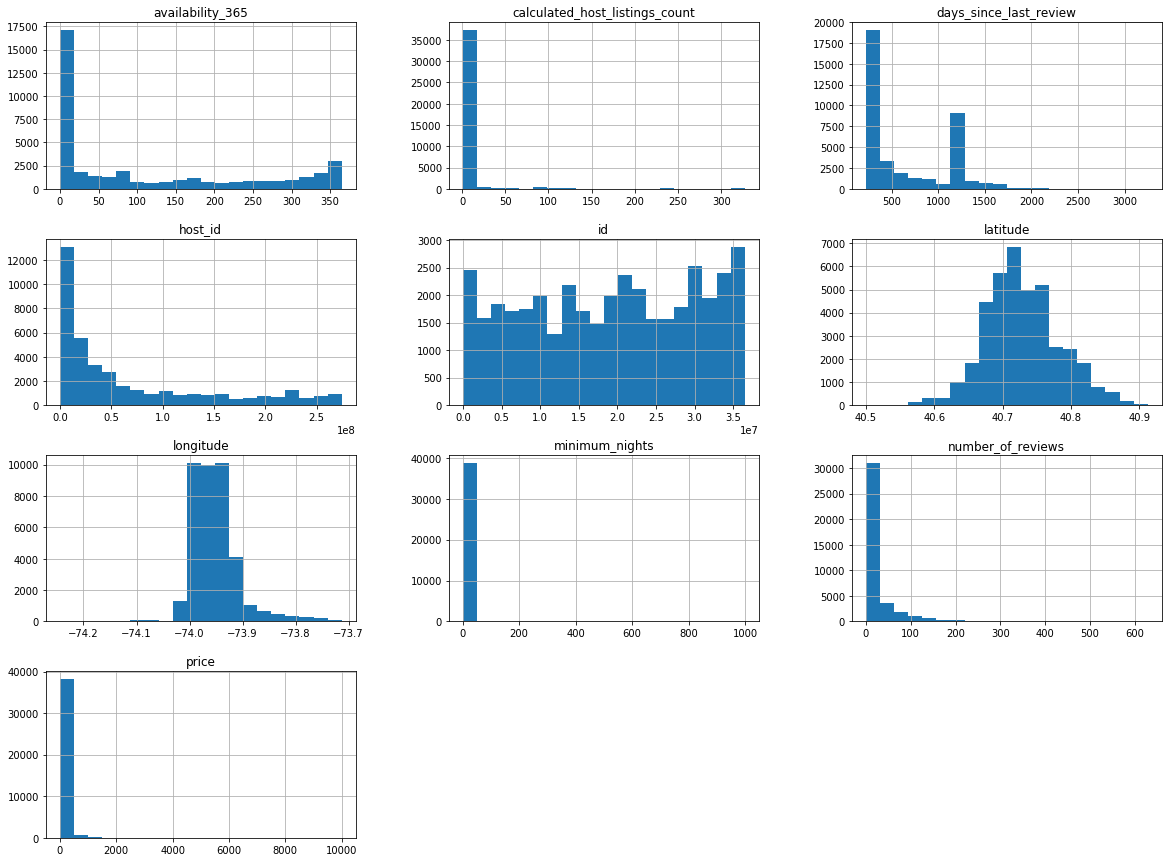

In [12]:
strat_train_set.hist(bins=20,figsize=(20,15))
#save_fig('bnb_histogram')
plot.show()

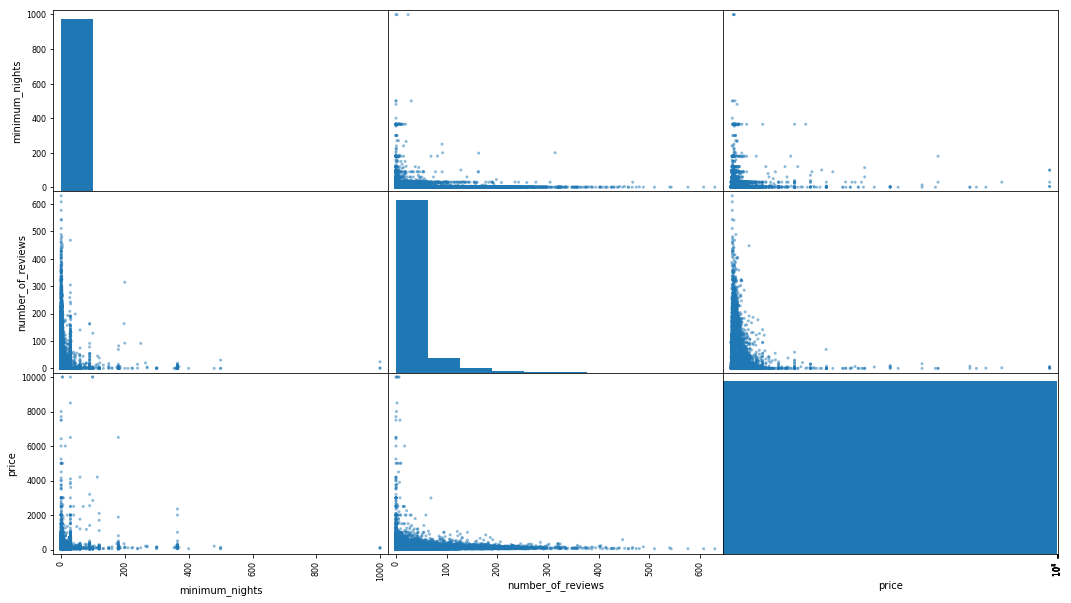

In [13]:
from pandas.plotting import scatter_matrix

scatter_matrix(strat_train_set[['minimum_nights', 'number_of_reviews', 'price']], figsize=[18,10])
plot.xscale('log')
plot.show()

In [14]:
strat_train_set.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review
47291,35677349,No Sleep Till Brooklyn!,222069293,Mariela,Brooklyn,Williamsburg,40.71556,-73.94245,Entire home/apt,275,3,0,1,362,1142
24491,19702498,Sunny 2BR Brooklyn Loft,5421054,Samuel,Brooklyn,Bushwick,40.70766,-73.92169,Entire home/apt,175,5,8,1,0,526
44681,34346014,Cosy crisp clean pad in Williamsburg,3203693,David,Brooklyn,Williamsburg,40.70996,-73.95121,Entire home/apt,100,6,1,1,7,229
17563,13812808,The trendiest block in Bedford Stuyvesant Broo...,81311292,Byron,Brooklyn,Bedford-Stuyvesant,40.68283,-73.94375,Private room,100,1,0,1,0,1142
29623,22747209,McSimon's | Cozy Private Studio | Near NYC,8113165,Cynthia And Froebel,Brooklyn,Canarsie,40.63762,-73.91004,Entire home/apt,95,3,4,2,108,410
14247,11037105,Sunny in heart of Williamsburg,57275881,Allegra,Brooklyn,Williamsburg,40.71187,-73.95566,Entire home/apt,250,1,0,1,0,1142
1264,542203,QUITE LOVELY STUDIO IN HEART OF HELLS KITCHEN**,1846051,Kj,Manhattan,Hell's Kitchen,40.76304,-73.98880,Entire home/apt,195,3,22,2,59,239
35251,27955820,24HR Doorman Condo&Gym 3Blocks From Time Squar...,58905707,Greg,Manhattan,Hell's Kitchen,40.76168,-74.00079,Entire home/apt,225,2,14,1,0,414
4974,3567258,Beautiful Loft in Union Square,298914,Fara,Manhattan,Gramercy,40.73711,-73.98985,Entire home/apt,220,4,60,1,4,238
28086,21926893,Studio with brand new furniture and appliances!,159998120,Joe,Queens,Astoria,40.76522,-73.92438,Entire home/apt,92,1,0,1,0,1142


In [15]:
strat_train_set['room_type'].value_counts()

Entire home/apt    20362
Private room       17844
Shared room          910
Name: room_type, dtype: int64

In [16]:
corr_matrix = strat_train_set.corr()
corr_matrix['price'].sort_values(ascending=False)

price                             1.000000
availability_365                  0.080223
days_since_last_review            0.057877
calculated_host_listings_count    0.057497
minimum_nights                    0.049901
latitude                          0.033109
host_id                           0.020321
id                                0.013344
number_of_reviews                -0.046461
longitude                        -0.146754
Name: price, dtype: float64

## Dropping unnecessary columns
### To be dropped:
- id
- name
- host_id
- host_name

In [17]:
train_labels = strat_train_set['price']
strat_train_set = strat_train_set.drop(['id', 'name', 'host_id', 'host_name', 'price'], axis=1)
strat_train_set.head()
train_labels

47291    275
24491    175
44681    100
17563    100
29623     95
        ... 
20020     95
22277     42
39811     40
2147      65
43811    352
Name: price, Length: 39116, dtype: int64

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cat_attribs = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Add more pre-processing for numerical values here
num_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

full_pipe = ColumnTransformer([
    ('num', num_pipe, list(strat_train_set.drop(cat_attribs, axis=1))),
    ('cat', OneHotEncoder(), cat_attribs)
])

train_prepared = full_pipe.fit_transform(strat_train_set)
train_prepared_copy = train_prepared.copy()

In [19]:
strat_train_set.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
days_since_last_review            0
dtype: int64

Finding the best hyperparameters using grid search

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tqdm

forest_reg = RandomForestRegressor()

grid_params = [
    {'n_estimators' : [80, 90, 100], 'max_features': [8, 9, 10], 'max_depth' : [15, 30, 50]}
]

grid_search = GridSearchCV(forest_reg, grid_params, return_train_score=True, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

grid_search.fit(train_prepared, train_labels)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 27.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [25]:
from sklearn.svm import SVR

sv_reg = SVR()

sv_params = [
    {'kernel': ['rbf'], 'C' : [1, 10], 'epsilon': [0.5, 0.1]}
]

sv_search = GridSearchCV(sv_reg, sv_params, return_train_score=True, scoring='neg_mean_squared_error',verbose=3, n_jobs=-1)

sv_search.fit(train_prepared_copy, train_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10], 'epsilon': [0.5, 0.1],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='explained_variance', verbose=3)

In [29]:
results =  grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'],results['params']):
    print(np.sqrt(-mean_score),params)

225.0181528109851 {'max_depth': 15, 'max_features': 8, 'n_estimators': 80}
225.25220521911433 {'max_depth': 15, 'max_features': 8, 'n_estimators': 90}
224.80190595399057 {'max_depth': 15, 'max_features': 8, 'n_estimators': 100}
224.11296633809155 {'max_depth': 15, 'max_features': 9, 'n_estimators': 80}
224.5189552104345 {'max_depth': 15, 'max_features': 9, 'n_estimators': 90}
223.7360845815837 {'max_depth': 15, 'max_features': 9, 'n_estimators': 100}
224.00820275168408 {'max_depth': 15, 'max_features': 10, 'n_estimators': 80}
224.26787533335613 {'max_depth': 15, 'max_features': 10, 'n_estimators': 90}
223.76454691919395 {'max_depth': 15, 'max_features': 10, 'n_estimators': 100}
221.234558025255 {'max_depth': 30, 'max_features': 8, 'n_estimators': 80}
220.20892907886275 {'max_depth': 30, 'max_features': 8, 'n_estimators': 90}
221.56738153782015 {'max_depth': 30, 'max_features': 8, 'n_estimators': 100}
220.3487632941144 {'max_depth': 30, 'max_features': 9, 'n_estimators': 80}
220.4454706

In [27]:
sv_results =  sv_search.cv_results_
for mean_score, params in zip(sv_results['mean_test_score'],sv_results['params']):
    print(np.sqrt(-mean_score),params)

nan {'C': 1, 'epsilon': 0.5, 'kernel': 'rbf'}
nan {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
nan {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
nan {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Latest results RandomForestRegressor (10/4/20):

``225.0181528109851 {'max_depth': 15, 'max_features': 8, 'n_estimators': 80}
225.25220521911433 {'max_depth': 15, 'max_features': 8, 'n_estimators': 90}
224.80190595399057 {'max_depth': 15, 'max_features': 8, 'n_estimators': 100}
224.11296633809155 {'max_depth': 15, 'max_features': 9, 'n_estimators': 80}
224.5189552104345 {'max_depth': 15, 'max_features': 9, 'n_estimators': 90}
223.7360845815837 {'max_depth': 15, 'max_features': 9, 'n_estimators': 100}
224.00820275168408 {'max_depth': 15, 'max_features': 10, 'n_estimators': 80}
224.26787533335613 {'max_depth': 15, 'max_features': 10, 'n_estimators': 90}
223.76454691919395 {'max_depth': 15, 'max_features': 10, 'n_estimators': 100}
221.234558025255 {'max_depth': 30, 'max_features': 8, 'n_estimators': 80}
**220.20892907886275 {'max_depth': 30, 'max_features': 8, 'n_estimators': 90}
221.56738153782015 {'max_depth': 30, 'max_features': 8, 'n_estimators': 100}
220.3487632941144 {'max_depth': 30, 'max_features': 9, 'n_estimators': 80}
220.4454706389553 {'max_depth': 30, 'max_features': 9, 'n_estimators': 90}
220.84507521187163 {'max_depth': 30, 'max_features': 9, 'n_estimators': 100}
220.63506884791465 {'max_depth': 30, 'max_features': 10, 'n_estimators': 80}
221.17963985971323 {'max_depth': 30, 'max_features': 10, 'n_estimators': 90}
220.95933825839992 {'max_depth': 30, 'max_features': 10, 'n_estimators': 100}
222.33059028971877 {'max_depth': 50, 'max_features': 8, 'n_estimators': 80}
221.72747033831237 {'max_depth': 50, 'max_features': 8, 'n_estimators': 90}
222.24915227966122 {'max_depth': 50, 'max_features': 8, 'n_estimators': 100}
221.37464129757825 {'max_depth': 50, 'max_features': 9, 'n_estimators': 80}
222.91040906820655 {'max_depth': 50, 'max_features': 9, 'n_estimators': 90}
222.25776315170438 {'max_depth': 50, 'max_features': 9, 'n_estimators': 100}
221.9337909181927 {'max_depth': 50, 'max_features': 10, 'n_estimators': 80}
221.75254620927407 {'max_depth': 50, 'max_features': 10, 'n_estimators': 90}
222.01642531214486 {'max_depth': 50, 'max_features': 10, 'n_estimators': 100}
``



Quick test predictions

In [ ]:
some_data = strat_train_set.iloc[20:30]
some_labels = train_labels.iloc[20:30]
some_data_prepared = full_pipe.transform(some_data)
print(grid_search.best_estimator_.predict(some_data_prepared))
print(some_labels.tolist())

In [ ]:
importances = grid_search.best_estimator_.feature_importances_
cat_encoder = full_pipe.named_transformers_["cat"]
one_hot_attribs = list(cat_encoder.categories_[0])
one_hot_attribs
attributes = list(strat_train_set.drop(cat_attribs, axis=1)) + one_hot_attribs
sorted(zip(attributes,importances), reverse=True)

In [ ]:
some_data_prepared[]